# Unprotected left turn with minimum violation planning
Nok Wongpiromsarn, 3 March 2020

## Problem description
This example illustrates the use of TuLiP to synthesize a minimum violation planner for system whose dynamics are described by a discrete transition system.

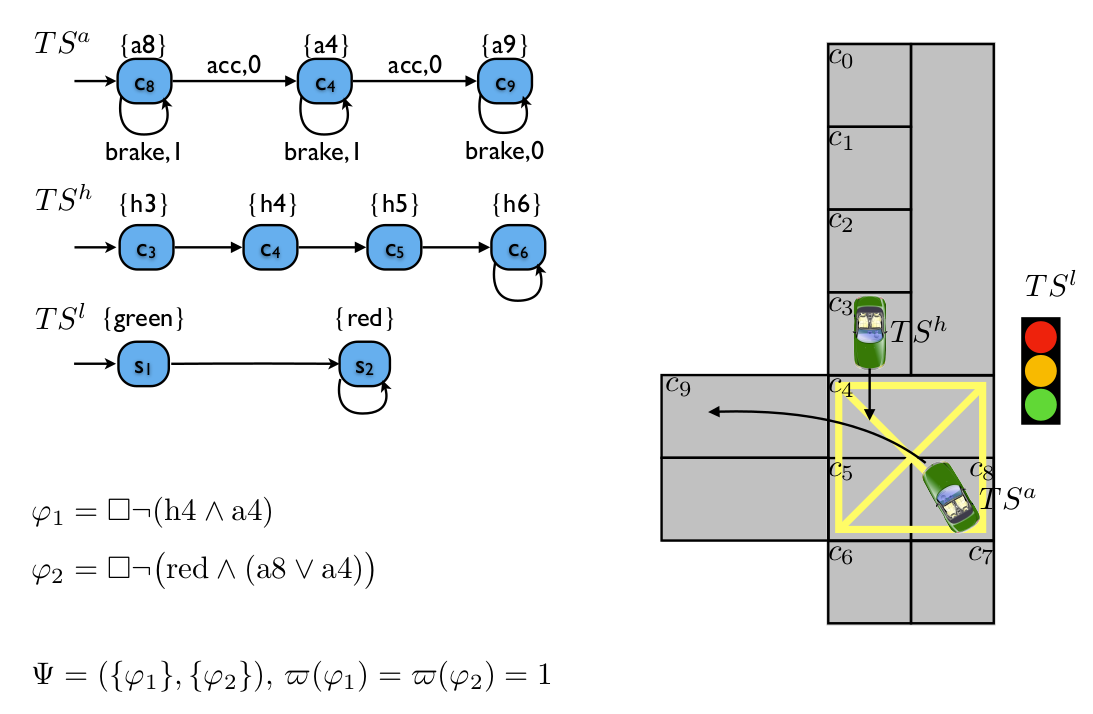

We begin by importing the packages and modules that we will need.

In [1]:
import copy
from tulip.transys import WeightedKripkeStructure as WKS
from tulip.transys.automata import WeightedFiniteStateAutomaton as WFA
from tulip.spec.prioritized_safety import PrioritizedSpecification
from tulip.transys.compositions import synchronous_parallel
from tulip.transys.mathset import PowerSet
from tulip.mvp import solve as solve_mvp

## System model

First, we define the necessary elements of each models.

In [2]:
states_a = {"c8", "c4", "c9"}
transitions_a = {
    ("c8", "c8", 1),
    ("c8", "c4", 0),
    ("c4", "c4", 1),
    ("c4", "c9", 0),
    ("c9", "c9", 0),
}
init_a = "c8"

states_h = {"c3", "c4", "c5", "c6"}
transitions_h = {
    ("c3", "c4"),
    ("c4", "c5"),
    ("c5", "c6"),
    ("c6", "c6"),
}
init_h = "c3"

states_l = {"green", "red"}
transitions_l = {
    ("green", "red"),
    ("red", "red"),
}
init_l = "green"

Now, we construct the weighted Kripke structure corresponding to each model from the above definitions. Recall that for each model, the set of states, initial states, transitions, the set of atomic propositions and the labeling function need to be defined. For the weighted transition system, we also need to define the cost of each transition.

In [3]:
ts_a = WKS()
ts_a.states.add_from(states_a)
ts_a.states.initial.add(init_a)
for transition in transitions_a:
    ts_a.transitions.add(
        transition[0], transition[1], {"cost": transition[2]}
    )
for s in states_a:
    ap = "a" + s[1:]
    ts_a.atomic_propositions.add(ap)
    ts_a.states[s]["ap"] = {ap}

ts_h = WKS()
ts_h.states.add_from(states_h)
ts_h.states.initial.add(init_h)
ts_h.transitions.add_from(transitions_h)
for s in states_h:
    ap = "h" + s[1:]
    ts_h.atomic_propositions.add(ap)
    ts_h.states[s]["ap"] = {ap}

ts_l = WKS()
ts_l.states.add_from(states_l)
ts_l.states.initial.add(init_l)
ts_l.transitions.add_from(transitions_l)
for s in states_l:
    ts_l.atomic_propositions.add(s)
    ts_l.states[s]["ap"] = {s}

Compose the model of each agent to obtain the complete system

In [4]:
ts = synchronous_parallel([ts_a, ts_h, ts_l])

## System specification

Define the finite automaton fa1 for []!(h4 & a4)

In [5]:
fa1 = WFA()
fa1.atomic_propositions.add_from(ts.atomic_propositions)
fa1.states.add_from({"q0"})
fa1.states.initial.add("q0")
fa1.states.accepting.add("q0")

To define the transition !(h4 & a4), we define 2 sets:
   * ap_without_h4 contains all the atomic propositions except 'h4'
   * ap_without_a4 contains all the atomic propositions except 'a4'
The subset of 2^{AP} corresponding to !(h4 & a4) is the union of
PowerSet(ap_without_h4) and PowerSet(ap_without_a4).

In [6]:
ap_without_h4 = copy.deepcopy(fa1.atomic_propositions)
ap_without_h4.remove("h4")
ap_without_a4 = copy.deepcopy(fa1.atomic_propositions)
ap_without_a4.remove("a4")
transition_letters = set(PowerSet(ap_without_h4)) | set(PowerSet(ap_without_a4))
for letter in transition_letters:
    fa1.transitions.add("q0", "q0", letter=letter)

## Exercise: Define the finite automaton fa2 for []!(red & (a8 | a4))

## Exercise: Define the prioritized safety specification

In [7]:
spec = PrioritizedSpecification()
spec.add_rule(fa1, priority=1, level=0)

## Controller synthesis

Solve the minimum violation planning problem

In [8]:
(cost, state_path, product_path, wpa) = solve_mvp(ts, "a9", spec)

Examine the result

In [9]:
print("Optimal cost: {}".format(cost))
print("State path: {}".format(state_path))
print("Product path: {}".format(product_path))

Optimal cost: [0, 1]
State path: [('c8', 'c3', 'green'), ('c8', 'c4', 'red'), ('c4', 'c5', 'red'), ('c9', 'c6', 'red')]
Product path: [('null', ('q0',)), (('c8', 'c3', 'green'), ('q0',)), (('c8', 'c4', 'red'), ('q0',)), (('c4', 'c5', 'red'), ('q0',)), (('c9', 'c6', 'red'), ('q0',))]


Examine the weighted product automaton

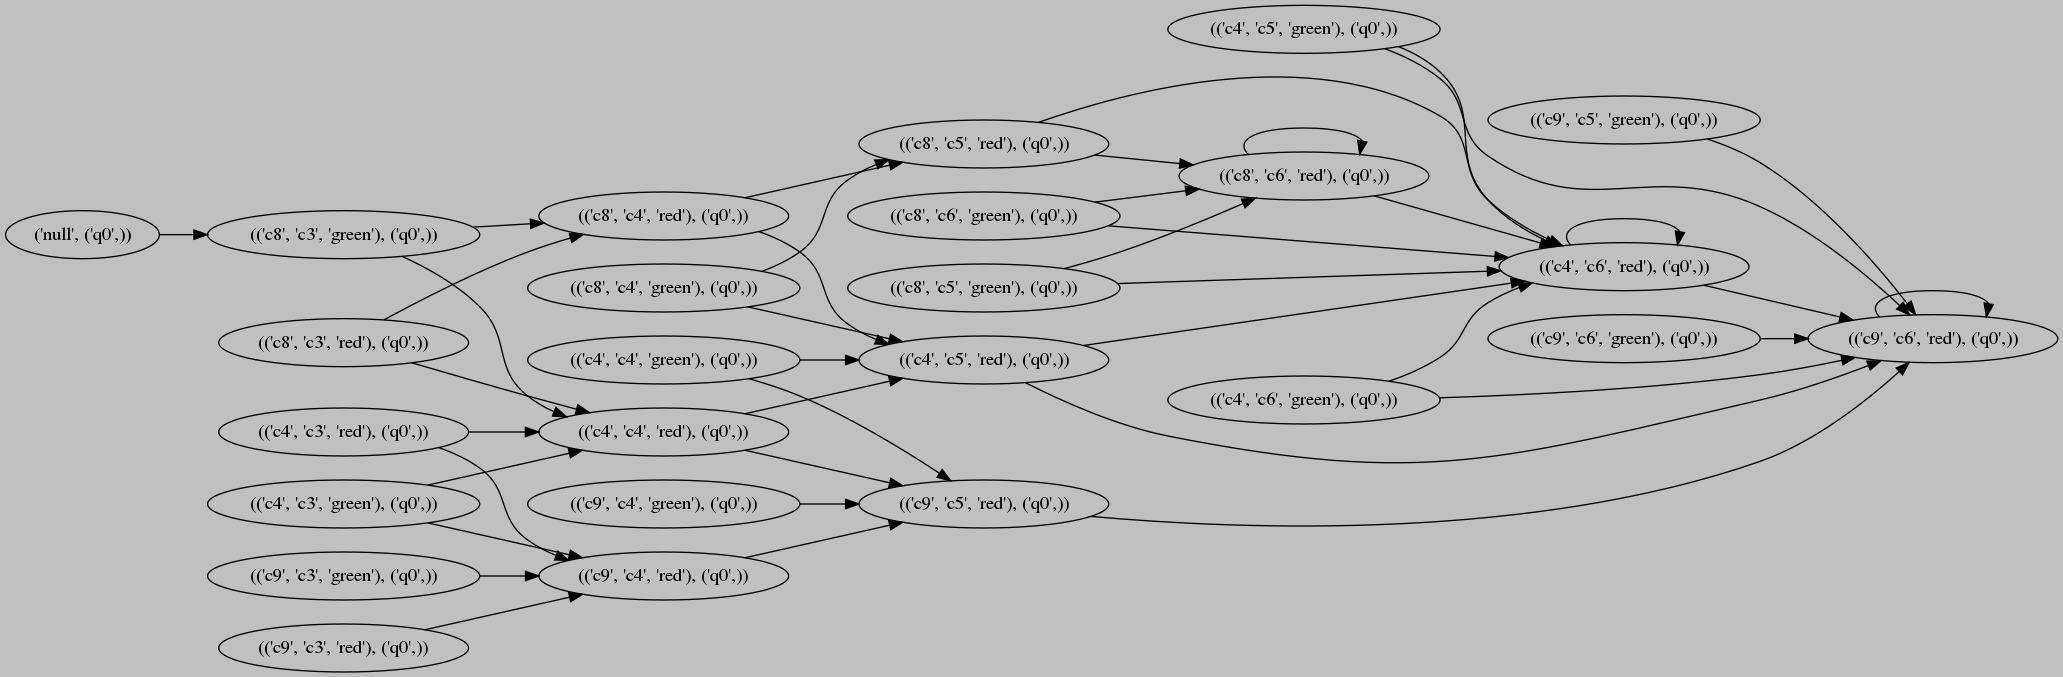

True

In [10]:
wpa.plot()

## Simulation

We can now generate a simulation to visualize the minimum violation trajectory of the system.

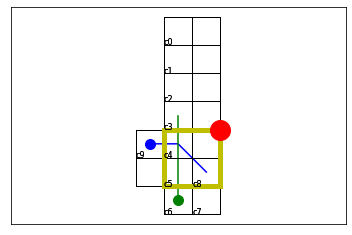

In [11]:
from IPython.display import HTML
import animate

loc_a = [state[0] for state in state_path]
loc_h = [state[1] for state in state_path]
light = [state[2] for state in state_path]

anim = animate.animate_intersection(light, (loc_a, loc_h))
HTML(anim.to_jshtml())

Alternatively, we can use tulip.gridworld model to do a more general simulation of paths

   0 1 2
  -------
 0| | | |
  -------
 1| | | |
  -------
 2| | | |
  -------
 3| | | |
  -------
 4| | | |
  -------
 5| | | |
  -------
 6| | | |
  -------



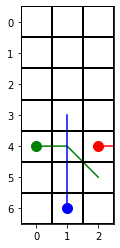

In [12]:
import tulip.gridworld as gw

world = gw.unoccupied((7, 3))
print(world)
gridloc = {
    'c0': (0, 1),
    'c1': (1, 1),
    'c2': (2, 1),
    'c3': (3, 1),
    'c4': (4, 1),
    'c5': (5, 1),
    'c6': (6, 1),
    'c7': (6, 2),
    'c8': (5, 2),
    'c9': (4, 0),
}

loc_a = [gridloc[state[0]] for state in state_path]
loc_h = [gridloc[state[1]] for state in state_path]
# light is out of the grid when it is green and 
# is at (4,2) when it is red
loc_l = [(4,3) if state[2]=="green" else (4,2) for state in state_path]

anim = gw.animate_paths(world, (loc_l, loc_a, loc_h))
HTML(anim.to_jshtml())